In [3]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display 


# Pretty display for notebooks
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

dataset = pd.read_csv("datasets/dataset_clean.csv.gz", compression='gzip')
dataset['RIESGO_VIDA'] = np.where(dataset['RIESGO_VIDA'] == 'si', 1,0)
dataset = dataset.drop(['Unnamed: 0'], axis = 1)
display(dataset.head(n = 5))

labels_raw = dataset[['RIESGO_VIDA']]
features_raw = dataset.drop(['RIESGO_VIDA'], axis = 1)

,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PET_COD_DEPTO,PET_DPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_TIPOATENCION,PQR_TIPOPETICION,RIESGO_VIDA,TRIM
0,bogota d.c.,de 13 a 17 años,ninguno,mujer,no aplica,bogotá,otro,no aplica,subsidiado,natural,...,11,bogota d.c.,bogotá,juridica,escrito,pqr,peticion directa,reclamo,0,trim i
1,nariño,de 0 a 5 años,ninguno,hombre,no aplica,puerres,otro,no aplica,subsidiado,natural,...,52,nariño,puerres,natural,telefonico,pqr,0,reclamo,0,trim i
2,valle,de 13 a 17 años,secundaria,hombre,no aplica,cali,abuelo (a),no aplica,contributivo,natural,...,76,valle,cali,natural,telefonico,pqr,0,reclamo,0,trim i
3,huila,de 13 a 17 años,universitario incompleto,hombre,no aplica,neiva,padre,no aplica,contributivo,natural,...,41,huila,neiva,natural,personalizado,pqr,0,reclamo,0,trim i
4,risaralda,de 13 a 17 años,ninguno,hombre,no aplica,dosquebradas,padre,persona en condición de discapacidad,contributivo,natural,...,66,risaralda,dosquebradas,natural,personalizado,pqr,0,reclamo,1,trim i


# Data Exploration

## Features Class Distribution

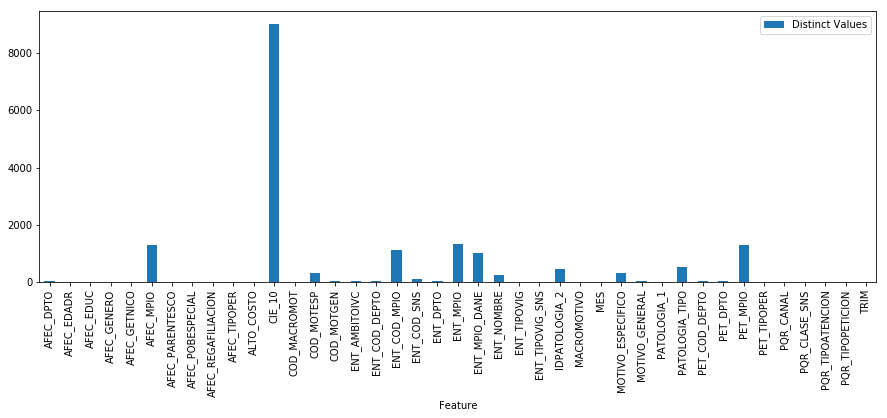

In [4]:

def getFeaturesDistribution(features):
    dfColumns = pd.DataFrame(columns=['Feature','Distinct Values'])
    for colName in features.columns.values:
        dfColumns = dfColumns.append({'Feature': colName, 'Distinct Values': features[colName].unique().size}, ignore_index=True)
    return dfColumns.infer_objects()

def showFeaturesDistribution(dfColumns):
    dfFeatures = dfColumns.copy(deep=True)
    dfFeatures.set_index("Feature",drop=True,inplace=True)
    dfFeatures.plot( kind='bar', figsize = (15,5))
dfColumns = getFeaturesDistribution(features_raw)
showFeaturesDistribution(dfColumns)


## Redundant features

These features represent the same data, so we can keep only the codes and loose the descripion.

* COD_MACROMOT = MACROMOTIVO
* COD_MOTGEN = MOTIVO_GENERAL
* COD_MOTESP = MOTIVO_ESPECIFICO
* ENT_COD_DEPTO = ENT_DPTO
* ENT_COD_MPIO = ENT_MPIO
* PET_COD_DEPTO = PET_DPTO

In [5]:
features_raw = features_raw.drop(['ENT_DPTO', 'ENT_MPIO', 'PET_DPTO', 'MACROMOTIVO', 'MOTIVO_GENERAL', 'MOTIVO_ESPECIFICO'], axis = 1)


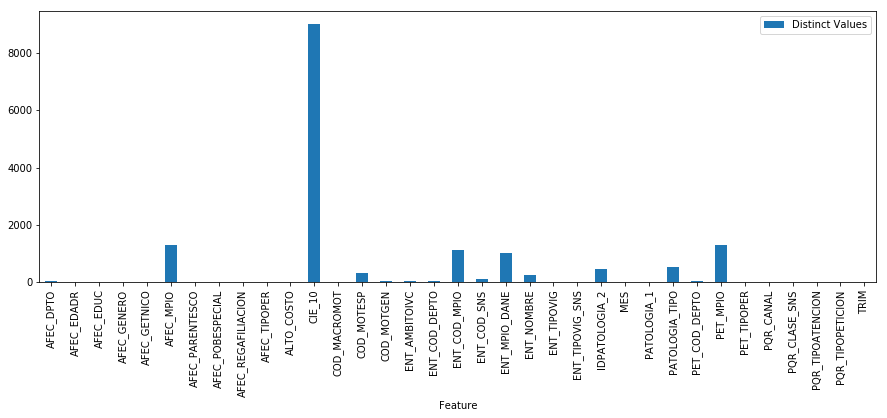

In [6]:
dfColumns = getFeaturesDistribution(features_raw)
showFeaturesDistribution(dfColumns)

In [7]:
features_raw = features_raw.applymap(str)


In [8]:
from __future__ import division
# TODO: Total number of records
n_records = dataset['RIESGO_VIDA'].count()

# TODO: Number of records where individual's life is at risk
life_risk = dataset[dataset["RIESGO_VIDA"] == 1]
n_life_risk = life_risk['RIESGO_VIDA'].count()

# TODO: Number of records where individual's life is not at risk
no_life_risk =  dataset[dataset["RIESGO_VIDA"] == 0]
n_no_life_risk = no_life_risk['RIESGO_VIDA'].count()

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_life_risk/n_records)*100

# Print the results
print "Total number of records: {:,}".format(n_records)
print "Individuals with life at risk: {:,}".format(n_life_risk)
print "Individuals with life not at risk: {:,}".format(n_no_life_risk)
print "Percentage of individuals with life at risk: {:.2f}%".format(greater_percent)

Total number of records: 2,130,783
Individuals with life at risk: 288,811
Individuals with life not at risk: 1,841,972
Percentage of individuals with life at risk: 13.55%


## Encoding dataset

All features in the dataset are categorical. Some of them have too many classes to be one hot encoded. Mean encoding transformation will be perform on the dataset to encode features.

In [9]:
features_columns = features_raw.columns.values.tolist()

In [10]:
from category_encoders import *
import time


start_time = time.time()   
enc = TargetEncoder(cols=features_raw.columns.values.tolist(), return_df = True).fit(features_raw, labels_raw)
dataset_encoded = enc.transform(features_raw)
print("--- %s seconds ---" % (time.time() - start_time))

display(dataset_encoded.head(n = 5))  


--- 1911.38802195 seconds ---


,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PATOLOGIA_1,PATOLOGIA_TIPO,PET_COD_DEPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_TIPOATENCION,PQR_TIPOPETICION,TRIM
0,0.172465,0.262627,0.179425,0.187490,0.217272,0.171278,0.264173,0.204179,0.280688,0.200446,...,0.151759,0.151759,0.122722,0.175819,0.101865,0.074075,0.240487,0.081491,0.2386,0.131762
1,0.199864,0.278952,0.179425,0.219439,0.217272,0.163793,0.264173,0.204179,0.280688,0.200446,...,0.151759,0.151759,0.146529,0.106796,0.138643,0.084191,0.240487,0.164131,0.2386,0.131762
2,0.221915,0.262627,0.210089,0.219439,0.217272,0.217327,0.319044,0.204179,0.178150,0.200446,...,0.151759,0.151759,0.144960,0.149912,0.138643,0.084191,0.240487,0.164131,0.2386,0.131762
3,0.299221,0.262627,0.315311,0.219439,0.217272,0.334056,0.308624,0.204179,0.178150,0.200446,...,0.151759,0.151759,0.234090,0.261161,0.138643,0.466574,0.240487,0.164131,0.2386,0.131762
4,0.208638,0.262627,0.179425,0.219439,0.217272,0.217398,0.308624,0.386519,0.178150,0.200446,...,0.404018,0.404018,0.151495,0.164382,0.138643,0.466574,0.240487,0.164131,0.2386,0.131762


In [11]:

# Log-transform the skewed features
skewed = features_columns
features_log_transformed = dataset_encoded.apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
display(features_log_transformed.head(n = 2))
#distribution(features_log_transformed, transformed = True)

,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PATOLOGIA_1,PATOLOGIA_TIPO,PET_COD_DEPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_TIPOATENCION,PQR_TIPOPETICION,TRIM
0,0.159108,0.233195,0.165027,0.171842,0.196613,0.158095,0.234418,0.185798,0.247397,0.182693,...,0.141291,0.141291,0.115756,0.161965,0.097005,0.071460,0.215504,0.078341,0.213982,0.123776
1,0.182208,0.246041,0.165027,0.198391,0.196613,0.151685,0.234418,0.185798,0.247397,0.182693,...,0.141291,0.141291,0.136739,0.101469,0.129838,0.080834,0.215504,0.151975,0.213982,0.123776


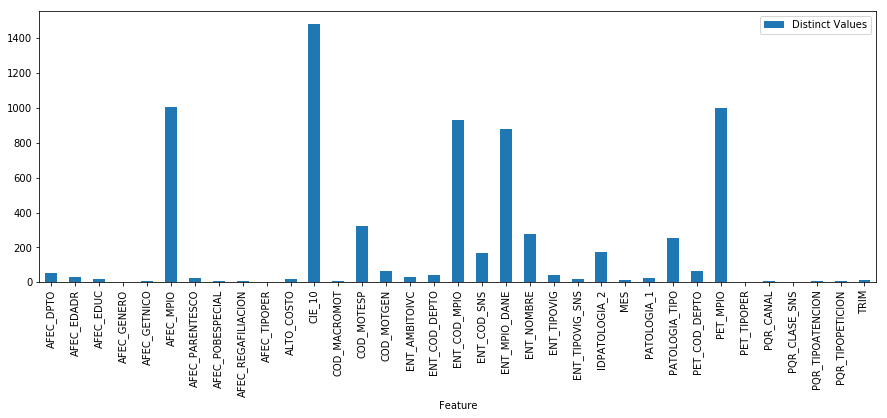

In [12]:

# Normalization with QuantileTransformer
from sklearn.preprocessing import QuantileTransformer

# Initialize a scaler, then apply it to the features
scaler = QuantileTransformer() # default=(0, 1)


features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[features_columns] = scaler.fit_transform(features_log_transformed[features_columns])

#distribution(features_log_minmax_transform, transformed = True)
# Show an example of a record with scaling applied
dfLogColumns = getFeaturesDistribution(features_log_minmax_transform)
showFeaturesDistribution(dfLogColumns)

In [13]:
display(features_log_minmax_transform.head(n = 5))

,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PATOLOGIA_1,PATOLOGIA_TIPO,PET_COD_DEPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_TIPOATENCION,PQR_TIPOPETICION,TRIM
0,0.585085,0.827077,0.592593,0.526527,0.727728,0.546547,0.857357,0.707708,1.000000,1.0,...,0.590591,0.608108,0.399399,0.821822,0.031031,0.039540,1.0,0.16967,0.804304,0.411912
1,0.737237,0.867868,0.592593,1.000000,0.727728,0.464909,0.857357,0.707708,1.000000,1.0,...,0.590591,0.608108,0.700701,0.405899,1.000000,0.597598,1.0,1.00000,0.804304,0.411912
2,0.862863,0.833333,0.789289,1.000000,0.727728,0.832332,0.919920,0.707708,0.574575,1.0,...,0.590591,0.608108,0.621622,0.640140,1.000000,0.597598,1.0,1.00000,0.804304,0.411912
3,0.980480,0.833333,1.000000,1.000000,0.727728,0.980480,0.912412,0.707708,0.574575,1.0,...,0.590591,0.608108,0.981982,0.974975,1.000000,1.000000,1.0,1.00000,0.804304,0.411912
4,0.750751,0.833333,0.592593,1.000000,0.727728,0.860861,0.912412,0.978979,0.574575,1.0,...,0.962462,0.961461,0.764765,0.709710,1.000000,1.000000,1.0,1.00000,0.804304,0.411912


# Store processed dataset

In [14]:
features_log_minmax_transform['RIESGO_VIDA'] = dataset['RIESGO_VIDA']
features_log_minmax_transform.to_csv("datasets/dataset.csv.gz", encoding='utf-8', compression = 'gzip')

# Feature Selection

In [ ]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = features_log_minmax_transform
y = dataset['RIESGO_VIDA']

# Feature extraction
test = SelectKBest(score_func=chi2, k=13)
fit = test.fit(X, y)

# Summarize scores
np.set_printoptions(precision=3)

X_new = fit.transform(X)
# Summarize selected features

mask = fit.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X.columns.values.tolist()):
    if bool:
        new_features.append(feature)

best_features = pd.DataFrame(X_new, columns=new_features)
display(best_features.head(n = 5))


## Store Dataset with best features

In [ ]:


best_features['RIESGO_VIDA'] = dataset['RIESGO_VIDA']
best_features.to_csv("datasets/dataset_best_features.csv.gz", encoding='utf-8', compression = 'gzip')

# Resampling

Target classes are highly unbalanced

In [ ]:
target_count = dataset['RIESGO_VIDA'].value_counts()
print(target_count)
target_count.plot(kind='bar', title='Count (target)');

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=300, return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(features_log_minmax_transform, dataset['RIESGO_VIDA'])

print('Removed indexes:', id_rus)


## Storing removed records for future model validation

In [ ]:
X_rus = pd.DataFrame(np.array(X_rus), columns=features_log_minmax_transform.columns.values.tolist())
y_rus = pd.DataFrame(np.array(y_rus), columns=['RIESGO_VIDA'])


dataset_rus = X_rus
dataset_rus['RIESGO_VIDA'] = y_rus

dataset_rus = pd.concat([features_log_minmax_transform,dataset_rus]).drop_duplicates(keep=False)

display(dataset_rus.head(n = 3))

dataset_rus.to_csv("datasets/dataset_under_sampled_validation.csv.gz", encoding='utf-8', compression = 'gzip')

In [ ]:
target_count_rus = y['RIESGO_VIDA'].value_counts()
print(target_count_rus)
target_count_rus.plot(kind='bar', title='Count (target)');

In [ ]:
X_rus['RIESGO_VIDA'] = y_rus['RIESGO_VIDA']
X_rus.to_csv("datasets/dataset_under_sampled.csv.gz", encoding='utf-8', compression = 'gzip')

## Over Sampling

In [ ]:
# Split the dataset to leave a separate dataset to verify the Over Sampled dataset is not overfitting
# Import train_test_split
from sklearn.model_selection import train_test_split

XOS_set, XOS_validation, yOS_set, yOS_validation = train_test_split(features_log_minmax_transform, 
                                                    dataset['RIESGO_VIDA'], 
                                                    test_size = 0.10, 
                                                    random_state = 10)

print "Training set has {} samples.".format(XOS_set.shape[0])
print "Validation set has {} samples.".format(XOS_validation.shape[0])


from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy = 'not majority')
X_ros, y_ros = ros.fit_sample(XOS_set, yOS_set)

print(X_ros.shape[0] - XOS_set.shape[0], 'new random picked points')


In [ ]:
X_ros = pd.DataFrame(np.array(X_ros), columns=features_log_minmax_transform.columns.values.tolist())
y_ros = pd.DataFrame(np.array(y_ros), columns=['RIESGO_VIDA'])

In [ ]:
target_count_ros = y_ros['RIESGO_VIDA'].value_counts()
print(target_count_ros)
target_count_ros.plot(kind='bar', title='Count (target)');

In [ ]:
X_ros['RIESGO_VIDA'] = y_ros[['RIESGO_VIDA']]
X_ros.to_csv("datasets/dataset_over_sampled.csv.gz", encoding='utf-8', compression = 'gzip')

XOS_validation['RIESGO_VIDA'] = pd.DataFrame(yOS_validation, columns = ['RIESGO_VIDA'])
XOS_validation.to_csv("datasets/dataset_over_sampled_validation.csv.gz", encoding='utf-8', compression = 'gzip')